In [1]:
import importlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns

from biosppy.signals import ecg, tools, ppg
from statannotations.Annotator import Annotator

import signal_utils as signal_functions
importlib.reload(signal_functions)

<module 'signal_utils' from '/home/siri/PycharmProjects/medical-metrics-analysis/src/signal_utils.py'>

In [2]:
# add directory of your data
path_parent = os.path.dirname(os.getcwd())
data_dir = os.path.join(path_parent, 'data/SENSEI_v2')

## uncomment when there are zipped files
#signal_functions.unzip_all(data_dir)

In [3]:
paths_ecg = signal_functions.find_paths(data_dir, 'ecg', 'ecg')
paths_label = signal_functions.find_csvs(data_dir, 'lab', '.csv')
num_users = len(paths_ecg)
print(paths_ecg)
print(paths_label)

['/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_178/vivalnk_vv330_ecg/20221108', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_223/vivalnk_vv330_ecg/20221114', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_642/vivalnk_vv330_ecg/20221109', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_661/vivalnk_vv330_ecg/20221110']
['/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_178/sensomative_labels/user_178_2022-11-08_13-30-38-951[1].csv', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_223/sensomative_labels/user_223_2022-11-14_15-32-35-310[1].csv', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_642/sensomative_labels/user_642_2022-11-09_13-22-11-209[1].csv', '/home/siri/PycharmProjects/medical-metrics-analysis/data/SENSEI_v2/user_sensei_661/sensomative_labels/user_661

user_sensei_178
user_sensei_223
user_sensei_642
user_sensei_661


<Figure size 432x288 with 0 Axes>

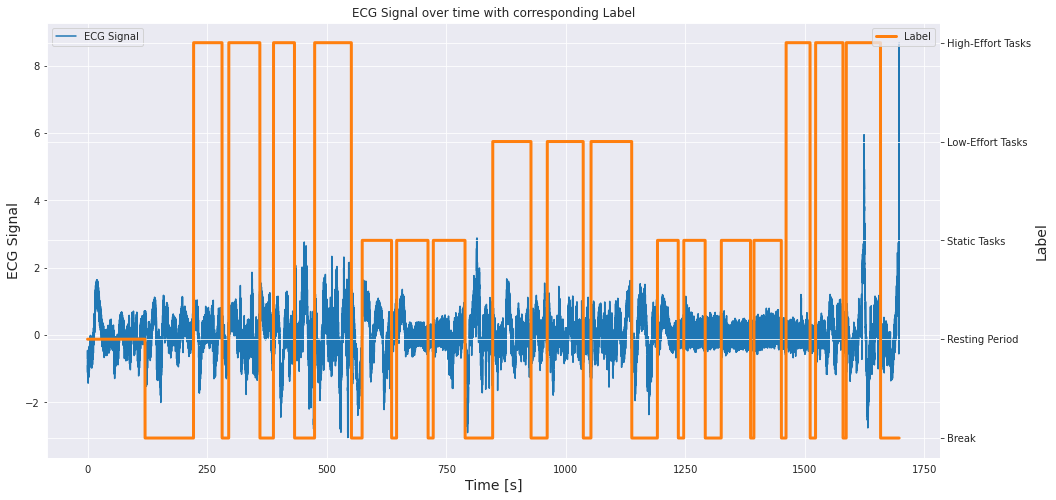

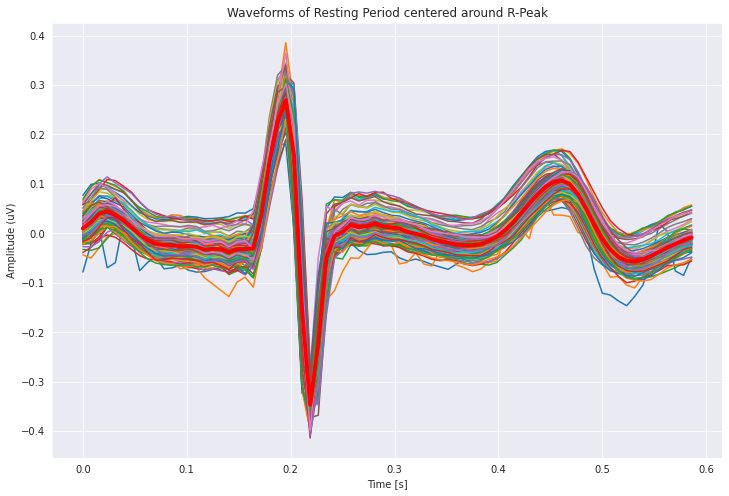

<Figure size 432x288 with 0 Axes>

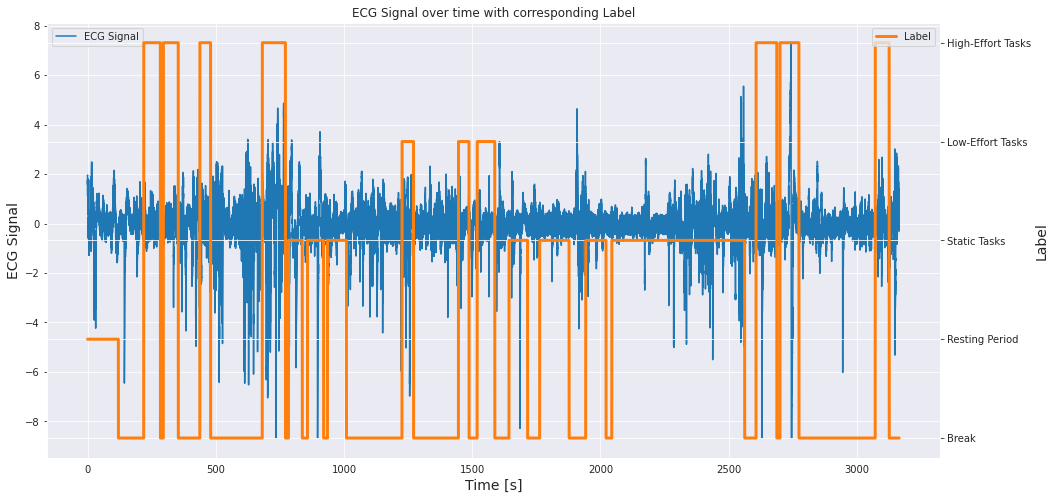

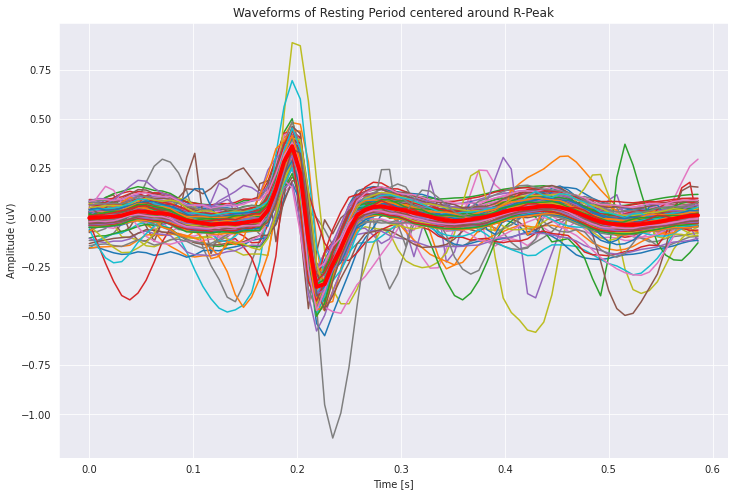

<Figure size 432x288 with 0 Axes>

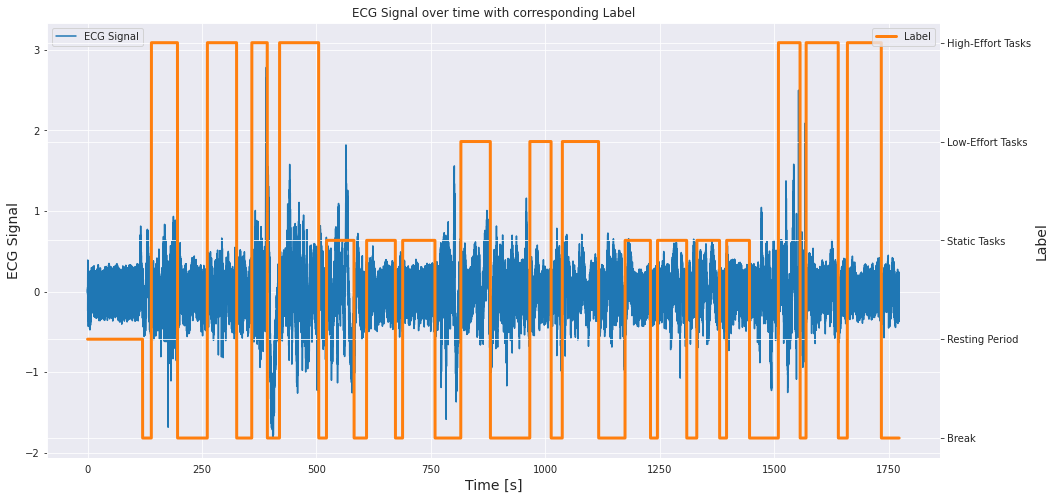

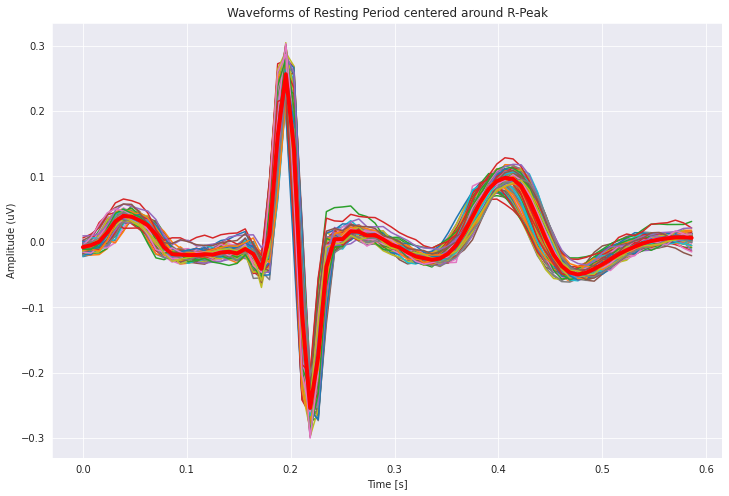

<Figure size 432x288 with 0 Axes>

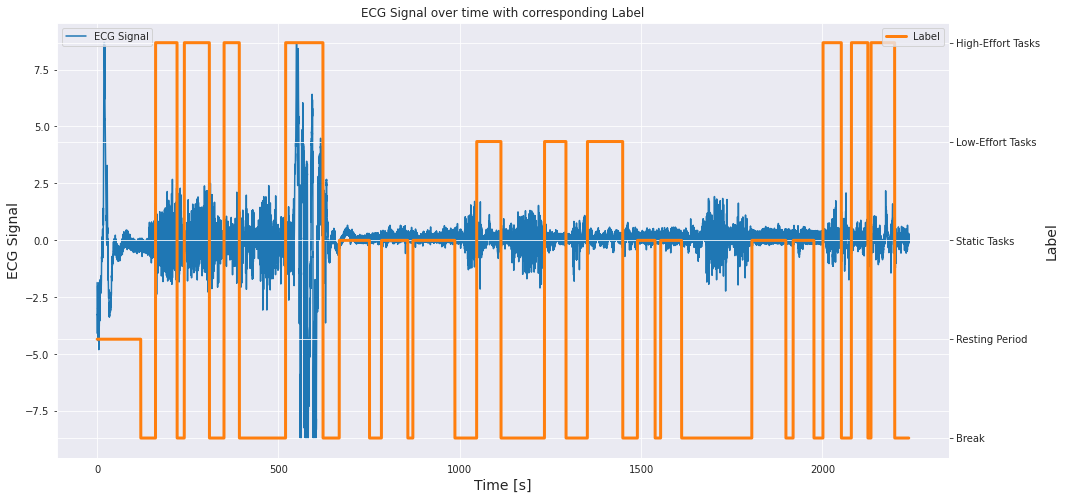

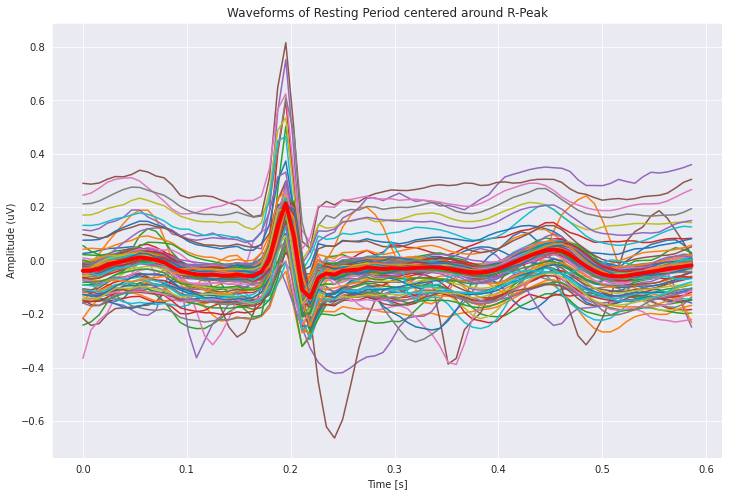

In [4]:
def analyse_adl(path_ecg, path_label, sf=128, show=True):
    df_ecg = signal_functions.combine_csv(path_ecg)
    df_labels = pd.read_csv(path_label)
    df_ecg_label = signal_functions.align_labels(df_ecg, df_labels)

    user_name = df_labels.userId[0]
    print(user_name)

    df_reclassified = signal_functions.reclassify_labels(df_ecg_label)

    df_clean = df_reclassified[df_reclassified.label>=-1]
    time_reset = df_clean.time - df_clean.time.iat[0]
    df_clean.insert(1, "time_reset", time_reset, True)
    df_clean_reset = df_clean.reset_index()


    if show:
        plt.figure()
        fig, ax = plt.subplots(figsize=(16, 8))

        ax.plot(df_clean.time_reset, df_clean.ecg)
        ax.set_xlabel("Time [s]", fontsize = 14)
        ax.set_ylabel("ECG Signal", fontsize = 14)
        ax.legend(['ECG Signal'], loc='upper left')

        ax2=ax.twinx()
        ax2.plot(df_clean.time_reset, df_clean.label, color="tab:orange", linewidth=3)
        ax2.set_ylabel("Label", fontsize = 14)
        x1 = [-1,0,1,2,3]
        squad = ['Break','Resting Period','Static Tasks','Low-Effort Tasks','High-Effort Tasks']
        ax2.set_yticks(x1, fontsize=30)
        ax2.set_yticklabels(squad, minor=False)
        ax2.legend(['Label'], loc='upper right')
        plt.title("ECG Signal over time with corresponding Label")

    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal=df_clean.ecg, sampling_rate=sf, show=False)
    hr_t, hr_v = tools.get_heart_rate(rpeaks,sf)
    ab,a_ind,b_ind=np.intersect1d(rpeaks,hr_t, return_indices=True)
    new_templates = np.take(templates, a_ind, axis=0)

    skewness, kurtosis, snr = signal_functions.calculate_sqi(new_templates, sf)

    user_num_vector = [user_name] * len(new_templates)
    labels = np.nan * len(new_templates)
    euc_dist = np.nan * len(new_templates)

    df_hr = pd.DataFrame({'user': user_num_vector, 'label': labels, 'time': heart_rate_ts, 'HR': heart_rate,'skewness': skewness, 'sqi_kurtosis': kurtosis, 'snr': snr,'euc_distance': euc_dist})

    df_hr_label = signal_functions.align_labels_to_hr(df_hr, df_clean_reset, feat_label="label")

    # calculate mean template of class 0
    class0 = df_hr_label[df_hr_label.label == 0].index.tolist()
    templates0 = np.take(new_templates, class0, axis=0)
    mean_waveform0 = np.nanmean(templates0, axis=0)

    # print mean waveform of class0
    euc0 = signal_functions.euc_dist_quality(templates0, mean_waveform0, sf, show=True, plt_title="Waveforms of Resting Period centered around R-Peak")

    # calculate euclidian distance from mean template of class 0
    euc_dist = signal_functions.euc_dist_quality(new_templates, mean_waveform0, sf)
    df_hr_label.euc_distance = euc_dist

    # remove rows without label
    df_hr_label = df_hr_label[np.isnan(df_hr_label.label)==False]

    # normalize the dataframe to class 0
    df_norm = signal_functions.normalize_to_userBaseline(df_hr_label, first_sqi_column=4)

    return df_hr_label, df_norm, user_name

df_adl = pd.DataFrame({'user': [], 'label': [], 'time': [], 'HR': [],'skewness': [], 'sqi_kurtosis': [], 'snr': [],'euc_distance': []})
df_adl_normalized = pd.DataFrame({'user': [], 'label': [], 'time': [], 'HR': [],'skewness': [], 'sqi_kurtosis': [], 'snr': [],'euc_distance': []})
users_list = []

for i in range(num_users):
    new_pd, new_pd_normalized, user_name = analyse_adl(paths_ecg[i], paths_label[i], show=True)
    df_adl = pd.concat([df_adl, new_pd], ignore_index=True)
    df_adl_normalized = pd.concat([df_adl_normalized, new_pd_normalized], ignore_index=True)
    users_list.append(user_name)

In [5]:
df_adl

,user,label,time,HR,skewness,sqi_kurtosis,snr,euc_distance
0,user_sensei_178,0.0,1.335938,75.050447,-0.794865,5.309308,0.037769,0.499777
1,user_sensei_178,0.0,2.140625,74.806777,1.251482,7.062452,0.025598,0.464534
2,user_sensei_178,0.0,2.945312,74.324122,-0.348667,7.523918,0.028246,0.337334
3,user_sensei_178,0.0,3.757812,74.085138,0.009799,7.394234,0.019798,0.329350
4,user_sensei_178,0.0,4.570312,75.089355,0.251162,7.503473,0.018396,0.328589
...,...,...,...,...,...,...,...,...
12208,user_sensei_661,-1.0,2234.218750,106.126258,1.829000,6.513101,0.022510,0.469300
12209,user_sensei_661,-1.0,2234.789062,110.953410,3.418754,16.812036,0.038259,0.325681
12210,user_sensei_661,-1.0,2235.367188,104.257682,2.870785,14.286143,0.028676,0.291270
12211,user_sensei_661,-1.0,2235.945312,103.322523,2.487778,12.178583,0.027983,0.261727


In [6]:
# Calculate the average length of a class in seconds

temp_label = 0.0
start = 0

zero_list = []
one_list = []
two_list = []
three_list = []

for i in range(len(df_adl)):
    if df_adl.label[i] != temp_label:
        end = df_adl.time[i]
        diff = end - start

        if temp_label == 0:
            zero_list.append(diff)
        if temp_label == 1:
            one_list.append(diff)
        if temp_label == 2:
            two_list.append(diff)
        if temp_label == 3:
            three_list.append(diff)

        temp_label = df_adl.label[i]
        start = df_adl.time[i]

print("Average total length of activities in resting period: ", sum(zero_list)/num_users)
print("Average total length of activities in static tasks: ", sum(one_list)/num_users)
print("Average total length of activities in low-effort tasks: ", sum(two_list)/num_users)
print("Average total length of activities in high-effort tasks: ", sum(three_list)/num_users)

Average total length of activities in resting period:  119.6484375
Average total length of activities in static tasks:  579.517578125
Average total length of activities in low-effort tasks:  201.921875
Average total length of activities in high-effort tasks:  439.8046875


### Signal Quality per Class

In [7]:
df_adl_mean = df_adl_normalized.groupby(['user', 'label']).mean()
df_adl_mean = df_adl_mean.reset_index(inplace=False)
df_adl_mean

,user,label,time,HR,skewness,sqi_kurtosis,snr,euc_distance
0,user_sensei_178,-1.0,NaN,NaN,3.567654,1.459294,4.170957,2.127967
1,user_sensei_178,0.0,NaN,NaN,0.021297,0.025475,0.053020,0.212439
2,user_sensei_178,1.0,NaN,NaN,3.397227,2.718278,0.915757,1.163695
3,user_sensei_178,2.0,NaN,NaN,2.279833,0.011746,7.478456,2.091183
4,user_sensei_178,3.0,NaN,NaN,4.002568,1.921788,8.994545,2.874486
5,user_sensei_223,-1.0,NaN,NaN,0.143940,-1.060835,5.400055,1.162824
6,user_sensei_223,0.0,NaN,NaN,0.113327,-0.320971,0.996693,0.453578
7,user_sensei_223,1.0,NaN,NaN,0.317481,-0.403664,2.951627,0.772060
8,user_sensei_223,2.0,NaN,NaN,-0.044049,-0.600792,3.845132,0.684070
9,user_sensei_223,3.0,NaN,NaN,0.523864,-2.331458,21.717254,2.291600


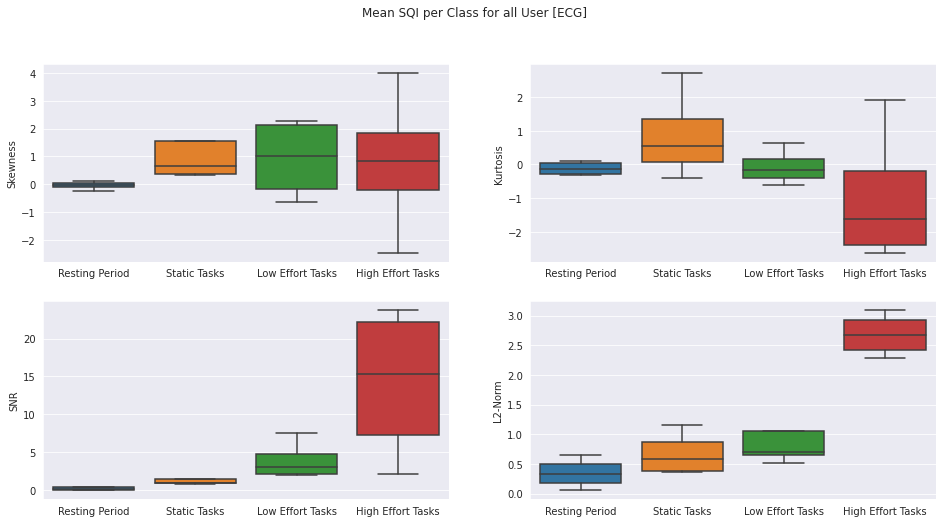

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('Mean SQI per Class for all User [ECG]')
plt.subplot(2, 2, 1)
p = sns.boxplot(y="skewness", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
p.set_xlabel(None);
p.set_ylabel("Skewness");
p.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

plt.subplot(2, 2, 2)
q = sns.boxplot(y="sqi_kurtosis", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
q.set_xlabel(None);
q.set_ylabel("Kurtosis");
q.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

plt.subplot(2, 2, 3)
u = sns.boxplot(y="snr", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
u.set_xlabel(None);
u.set_ylabel("SNR");
u.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

plt.subplot(2, 2, 4)
v = sns.boxplot(y="euc_distance", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
v.set_xlabel(None);
v.set_ylabel("L2-Norm");
v.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

#### Pairwise Tukey for Signal Quality

In [9]:
pt = pg.pairwise_tukey(dv='skewness', between='label', data=df_adl_mean[df_adl_mean.label >= 0]).round(5)
print(pt)

     A    B  mean(A)  mean(B)     diff       se        T  p-tukey   hedges
0  0.0  1.0 -0.03675  1.25778 -1.29453  1.18892 -1.08883  0.70262 -0.66950
1  0.0  2.0 -0.03675  0.91933 -0.95608  1.18892 -0.80416  0.85123 -0.49446
2  0.0  3.0 -0.03675  0.79997 -0.83672  1.18892 -0.70376  0.89366 -0.43273
3  1.0  2.0  1.25778  0.91933  0.33845  1.18892  0.28467  0.99153  0.17504
4  1.0  3.0  1.25778  0.79997  0.45781  1.18892  0.38507  0.97968  0.23677
5  2.0  3.0  0.91933  0.79997  0.11937  1.18892  0.10040  0.99962  0.06173


In [10]:
pt = pg.pairwise_tukey(dv='sqi_kurtosis', between='label', data=df_adl_mean[df_adl_mean.label >= 0]).round(5)
print(pt)

     A    B  mean(A)  mean(B)     diff       se        T  p-tukey   hedges
0  0.0  1.0 -0.12174  0.85962 -0.98137  0.89802 -1.09281  0.70035 -0.67194
1  0.0  2.0 -0.12174 -0.06641 -0.05533  0.89802 -0.06162  0.99991 -0.03789
2  0.0  3.0 -0.12174 -0.97588  0.85414  0.89802  0.95113  0.77861  0.58483
3  1.0  2.0  0.85962 -0.06641  0.92603  0.89802  1.03119  0.73511  0.63405
4  1.0  3.0  0.85962 -0.97588  1.83550  0.89802  2.04394  0.22604  1.25677
5  2.0  3.0 -0.06641 -0.97588  0.90947  0.89802  1.01275  0.74532  0.62271


In [11]:
pt = pg.pairwise_tukey(dv='snr', between='label', data=df_adl_mean[df_adl_mean.label >= 0]).round(5)
print(pt)

     A    B  mean(A)   mean(B)      diff       se        T  p-tukey   hedges
0  0.0  1.0  0.29576   1.38090  -1.08515  3.79228 -0.28615  0.99141 -0.17594
1  0.0  2.0  0.29576   3.84494  -3.54918  3.79228 -0.93590  0.78662 -0.57546
2  0.0  3.0  0.29576  14.14333 -13.84757  3.79228 -3.65152  0.01518 -2.24523
3  1.0  2.0  1.38090   3.84494  -2.46403  3.79228 -0.64975  0.91362 -0.39952
4  1.0  3.0  1.38090  14.14333 -12.76242  3.79228 -3.36537  0.02506 -2.06928
5  2.0  3.0  3.84494  14.14333 -10.29839  3.79228 -2.71562  0.07709 -1.66977


In [12]:
pt = pg.pairwise_tukey(dv='euc_distance', between='label', data=df_adl_mean[df_adl_mean.label >= 0]).round(5)
print(pt)

     A    B  mean(A)  mean(B)     diff       se        T  p-tukey   hedges
0  0.0  1.0  0.34462  0.67138 -0.32675  0.33226 -0.98342  0.76133 -0.60468
1  0.0  2.0  0.34462  0.99924 -0.65462  0.33226 -1.97019  0.25184 -1.21142
2  0.0  3.0  0.34462  2.67914 -2.33451  0.33226 -7.02615  0.00007 -4.32021
3  1.0  2.0  0.67138  0.99924 -0.32786  0.33226 -0.98677  0.75952 -0.60674
4  1.0  3.0  0.67138  2.67914 -2.00776  0.33226 -6.04273  0.00029 -3.71553
5  2.0  3.0  0.99924  2.67914 -1.67990  0.33226 -5.05596  0.00139 -3.10879


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0 vs. 3.0: *
0.0 vs. 3.0: *
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0 vs. 3.0: *
1.0 vs. 3.0: *
0.0 vs. 3.0: *


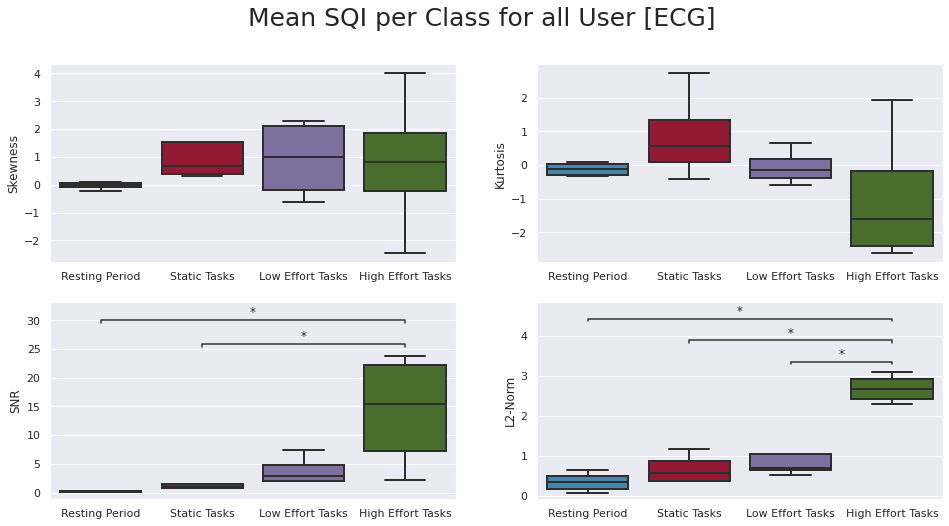

In [13]:
plotting_parameters1 = {
    'data':    df_adl_mean[df_adl_mean.label >= 0],
    'x':       'label',
    'y':       'snr',
    'showfliers': False
}

pairs1 = [(0, 3),
          (1, 3)]

formatted_pvalues1=['*', '*']

plotting_parameters2 = {
    'data':    df_adl_mean[df_adl_mean.label >= 0],
    'x':       'label',
    'y':       'euc_distance',
    'showfliers': False
}

pairs2 = [(0,3),
          (1,3),
          (2,3)]

formatted_pvalues2=['*', '*', '*']

with sns.plotting_context('notebook'):
    # Create new plot
    fig, axes= plt.subplots(2, 2, figsize=(16, 8))
    fig.suptitle('Mean SQI per Class for all User [ECG]', fontsize=25)

    plt.style.use("bmh")
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams["axes.facecolor"] = "white"

    plt.subplot(2, 2, 1)
    p = sns.boxplot(y="skewness", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
    p.set_xlabel(None);
    p.set_ylabel("Skewness");
    p.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

    plt.style.use("bmh")
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams["axes.facecolor"] = "white"

    plt.subplot(2, 2, 2)
    q = sns.boxplot(y="sqi_kurtosis", x="label", data=df_adl_mean[df_adl_mean.label >= 0], showfliers = False);
    q.set_xlabel(None);
    q.set_ylabel("Kurtosis");
    q.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

    plt.style.use("bmh")
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams["axes.facecolor"] = "white"

    plt.subplot(2, 2, 3)
    # Plot with seaborn
    sns.boxplot(**plotting_parameters1)

    plt.style.use("bmh")
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams["axes.facecolor"] = "white"

    # Add annotations
    annotator = Annotator(axes[1, 0], pairs1, **plotting_parameters1)
    annotator.set_custom_annotations(formatted_pvalues1)
    annotator.annotate()

    axes[1, 0].set_xlabel(None);
    axes[1, 0].set_ylabel("SNR");
    axes[1, 0].set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

    plt.subplot(2, 2, 4)
    # Plot with seaborn
    sns.boxplot(**plotting_parameters2)

    plt.style.use("bmh")
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams["axes.facecolor"] = "white"

    # Add annotations
    annotator = Annotator(axes[1, 1], pairs2, **plotting_parameters2)
    annotator.set_custom_annotations(formatted_pvalues2)
    annotator.annotate()

    axes[1, 1].set_xlabel(None);
    axes[1, 1].set_ylabel("L2-Norm");
    axes[1, 1].set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

    # Label and show
    plt.show()

### Completeness of good-quality data

In [14]:
folder_path = os.path.join(path_parent,'src')
if not os.path.isdir(folder_path +"/output"):
    os.makedirs(folder_path+"/output")

df_pass_rates = pd.DataFrame()
consecutive_list = []
for user in users_list:
    df_user = df_adl[df_adl.user==user]
    df_norm = signal_functions.normalize_to_userBaseline(df_user).drop(columns='user')
    df_thresholds, passing_rate = signal_functions.threshold_analysis(df_norm, show=False)
    df_user = df_user.assign(final=df_thresholds.final)

    file_name = "output/ecg_hr_" + str(user) + ".csv"
    fullname = os.path.join(folder_path, file_name)
    df_user.to_csv(fullname, index=True)

    temp_value = 0
    for value in df_thresholds.final:
        if temp_value > 0:
            if value:
                consecutive_list.append(temp_value)
                temp_value = 0
            else:
                temp_value = temp_value + 1
        else:
            if not value:
                temp_value = 1

    passing_rate = pd.DataFrame([passing_rate])
    df_pass_rates = pd.concat([df_pass_rates, passing_rate], ignore_index=True)

file_name = "output/ecg_users_passing_rates.csv"
fullname = os.path.join(folder_path, file_name)
df_pass_rates.to_csv(fullname, index=True)

#print("Maximum of consecutive False is: ", max(consecutive_list))
#plt.hist(consecutive_list, 20);

In [15]:
df_pass_rates

,0,1,2,3
0,86.131387,22.718053,21.612903,7.325383
1,89.808917,75.848461,76.497696,66.205837
2,87.421384,62.673611,29.710145,18.027735
3,91.975309,66.494179,80.530973,50.082102


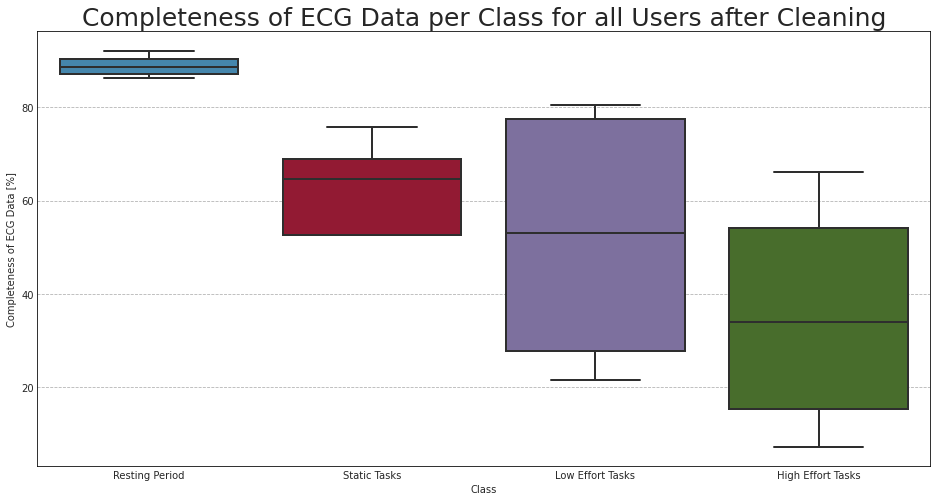

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use("bmh")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
sns.boxplot(data=df_pass_rates,showfliers=False);
ax.set_title('Completeness of ECG Data per Class for all Users after Cleaning', fontsize=25);
ax.set_xlabel("Class");
ax.set_ylabel("Completeness of ECG Data [%]");
ax.set_xticklabels(('Resting Period', 'Static Tasks','Low Effort Tasks', 'High Effort Tasks'));

#### Pairwise Tukey for Data Completeness

In [17]:
df_split_passrates = pd.melt(df_pass_rates)
pt = pg.pairwise_tukey(dv='value', between='variable', data=df_split_passrates)
print(pt)

   A  B    mean(A)    mean(B)       diff         se         T   p-tukey  \
0  0  1  88.834249  56.933576  31.900673  16.785193  1.900525  0.278244   
1  0  2  88.834249  52.087929  36.746320  16.785193  2.189210  0.181403   
2  0  3  88.834249  35.410264  53.423985  16.785193  3.182804  0.034489   
3  1  2  56.933576  52.087929   4.845646  16.785193  0.288686  0.991180   
4  1  3  56.933576  35.410264  21.523312  16.785193  1.282280  0.590347   
5  2  3  52.087929  35.410264  16.677665  16.785193  0.993594  0.755812   

     hedges  
0  1.168586  
1  1.346092  
2  1.957028  
3  0.177506  
4  0.788442  
5  0.610936  
